This is step 3. There 9 hardware shift positions. Data analysis: In each hardware shift position, there are 3 different repetitions. We conducts the training and testing like this: Use 3-validation by training 2 repetitions in all 9 hardware shifting and testing the rest repetetion in all 9 hardware shifting. 
Note: We only use the virtual shifting for self-supervised learning 

1. Define necessary modules, class, functions

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from data_loader import CustomSignalData, CustomSignalData1
from torch.autograd import Variable
from encoder import Encoder as E
from helpers import set_cmd_cb, rms_formuula, get_data, get_all_data, get_shift_data, get_operators, plot_cfs_mat, roll_data

DEVICE = torch.device("cpu")
def getFeatureMatrix(rawDataMatrix, windowLength, windowOverlap):
    rms = lambda sig: np.sqrt(np.mean(sig**2))
    nChannels,nSamples = rawDataMatrix.shape    
    I = int(np.floor(nSamples/(windowLength-windowOverlap)))
    featMatrix = np.zeros([nChannels, I])
    for channel in range(nChannels):
        for i in range (I):
            wdwStrtIdx=i*(windowLength-windowOverlap)
            sigWin = rawDataMatrix[channel][wdwStrtIdx:(wdwStrtIdx+windowLength-1)] 
            featMatrix[channel, i] = rms(sigWin)
    featMatrixData = np.array(featMatrix)
    return featMatrixData

class FFNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(FFNN, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(inputSize, 9, bias=False),
            torch.nn.Sigmoid()
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(9, outputSize, bias=False),
            # torch.nn.Softmax(dim=1)
        )

    def forward(self, x, encoder=None):
        if not encoder:
            encoder = self.encoder
        z = encoder(x)
        class_z = self.classifer(z)

        return class_z

class Operator(nn.Module):
    def __init__(self, in_features, n_rotations):
        super(Operator, self).__init__()
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.core = torch.nn.Parameter(torch.zeros(3*self.in_features**2)- 0*torch.diag(torch.rand(3*self.in_features**2)/10))
        self.core.requires_grad = True
        self.n_rotations = n_rotations
        
    def rotate_batch(self, x, d, out_features):
      rotated = torch.empty(x.shape[0], 3*out_features*out_features, device=DEVICE)
      phies = [torch.linalg.matrix_power(self.core,i).to(DEVICE) for i in range (0,self.n_rotations+0)]
      for i in range (x.shape[0]):
        rotated[i] = phies[(d[i]+0)%4].matmul(x[i]) 
      return rotated

    def forward(self, x, d):
        """
        Args:
          x of shape (batch_size, 3, xsize, xsize): Inputs.
        
        Returns:
          y of shape (batch_size, 3*xsize^2): Outputs.
        """
        z = self.rotate_batch(x, d, self.in_features)
        return z
def get_tensor(arr):
    return torch.tensor(arr, device=DEVICE,dtype=torch.float )

def rotate_batch(x, d, out_features):
    M = torch.diag(torch.ones(8)).roll(-1,1)
    used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)]
    rotated = torch.empty(x.shape, device=DEVICE)
    for i in range (x.shape[0]):
        rotated[i] = used_bases[d[i]].matmul(x[i]) 
    return rotated

def clf_acc(model, loader, masks = None, encoder = None):
    model.eval()
    correct = 0
    iter = 0
    with torch.no_grad():
        for inputs, labels,_,_ in loader:
            inputs = inputs.to(DEVICE)
            if masks is not None:
                inputs = inputs * masks[:inputs.size()[0]]
            labels = labels.to(DEVICE)
            labels = labels.flatten()
            if encoder:
                pred = model(inputs, encoder)
            else:
                pred = model(inputs)
            correct += (1-torch.abs(torch.sign(torch.argmax(pred,dim = 1)- labels))).mean().item()
            iter += 1
    return correct/iter

def compute_accuracy(a, b, loader):
    a.eval()
    b.eval()
    
    correct = 0
    iter = 0
    
    with torch.no_grad():
        for inputs1, inputs2, shift1, shift2, labels, _ in loader:
            inputs1 = inputs1.to(DEVICE)
            inputs2 = inputs2.to(DEVICE)
            shift1 = -shift1.int().flatten().to(DEVICE)
            shift2 = -shift2.int().flatten().to(DEVICE)
            labels = labels.flatten().to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y1 = a(inputs1)
            y_tr_est1 = rotate_batch(y1,shift1,6)
            y_tr1 = b(y_tr_est1)

            y2 = a(inputs2)
            y_tr_est2 = rotate_batch(y2,shift1,6)
            y_tr2 = b(y_tr_est2)

            correct += (1-torch.abs(torch.sign(torch.argmax(y_tr1,dim = 1)- labels))).mean().item() + \
                    (1-torch.abs(torch.sign(torch.argmax(y_tr2,dim = 1)- labels))).mean().item()
            iter += 1
    return correct * 0.5 / iter

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Split data into training and testing dataset

In [2]:
subject = '26'

Fs = 1000
windowLength = int(np.floor(0.1*Fs))  #160ms
windowOverlap =  int(np.floor(50/100 * windowLength))

X_train = [np.zeros([0, 8]) for _ in range(3)]
y_train = [np.zeros([0]) for _ in range(3)]
X_test = [np.zeros([0, 8]) for _ in range(3)]
y_test = [np.zeros([0]) for _ in range(3)]

for k_fold in range(0, 3): 
    for shift in range(0,9): 
        for files in sorted(os.listdir(f'Subject_{subject}/Shift_{shift}/')):
            _, class_,_, rep_ = files.split('_')
            
            df = pd.read_csv(f'Subject_{subject}/Shift_{shift}/{files}',skiprows=0,sep=' ',header=None)
            data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
            data_arr -= 121
            data_arr /= 255.0
            feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
            
            if not class_.startswith('9'):
                rms_feature = feaData.sum(0)
                baseline = 2*rms_feature[-50:].mean()
                start_ = np.argmax(rms_feature[::1]>baseline)
                end_  = -np.argmax(rms_feature[::-1]>baseline)
                feaData = feaData.T[start_:end_]
            else:
                feaData = feaData.T
            
            
            if rep_.startswith(str(k_fold+1)):
                X_test[k_fold] = np.concatenate([X_test[k_fold],feaData])
                y_test[k_fold] = np.concatenate([y_test[k_fold],np.ones_like(feaData)[:,0]*int(class_)-1])
            else:
                X_train[k_fold] = np.concatenate([X_train[k_fold],feaData])
                y_train[k_fold] = np.concatenate([y_train[k_fold],np.ones_like(feaData)[:,0]*int(class_)-1])

In [3]:
print("Training dataset feature:")
print(X_train[1].shape)
print("Training dataset label:")
print(y_train[1].shape)
print("Testing dataset feature:")
print(X_test[1].shape)
print("Testing dataset label:")
print(y_test[1].shape)

Training dataset feature:
(41977, 8)
Training dataset label:
(41977,)
Testing dataset feature:
(20993, 8)
Testing dataset label:
(20993,)


2. Logistic Regression

2.1 Training learning model

In [4]:
for k_fold in range(3):
    reg = LogisticRegression(penalty='l2', C=100).fit(X_train[k_fold], y_train[k_fold])
    dump(reg, f'LogisticRegression_fold_{k_fold+1}_app3.joblib')


/home/eea-10/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/eea-10/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

2.2 Test accuracy

In [7]:
accuracies_LosReg_list = []

for k_fold in range(3):
    logRegres  = load(f'LogisticRegression_fold_{k_fold+1}_app3.joblib')
    accuracy = logRegres.score(X_test[k_fold],y_test[k_fold])
    accuracies_LosReg_list.append(accuracy)

print(accuracies_LosReg_list)

[0.41190498902985784, 0.4197589672748059, 0.4212079386987768]


In [8]:
value_average_accuracies_LosReg = sum(accuracies_LosReg_list) / 3 
print(value_average_accuracies_LosReg)

0.41762396500114685


Confusion matrix 

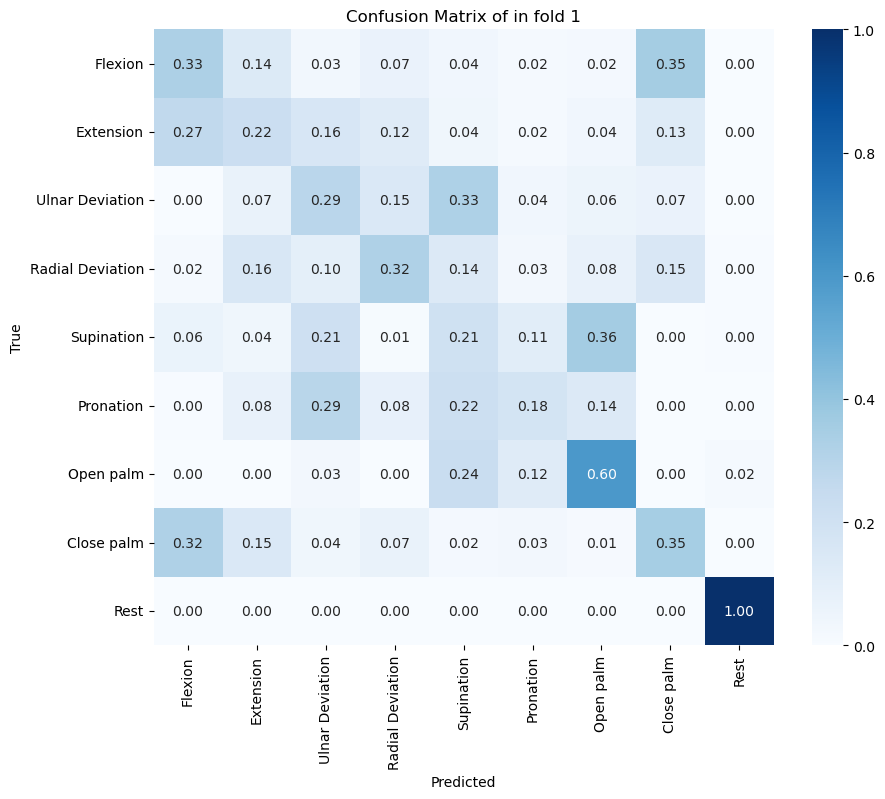

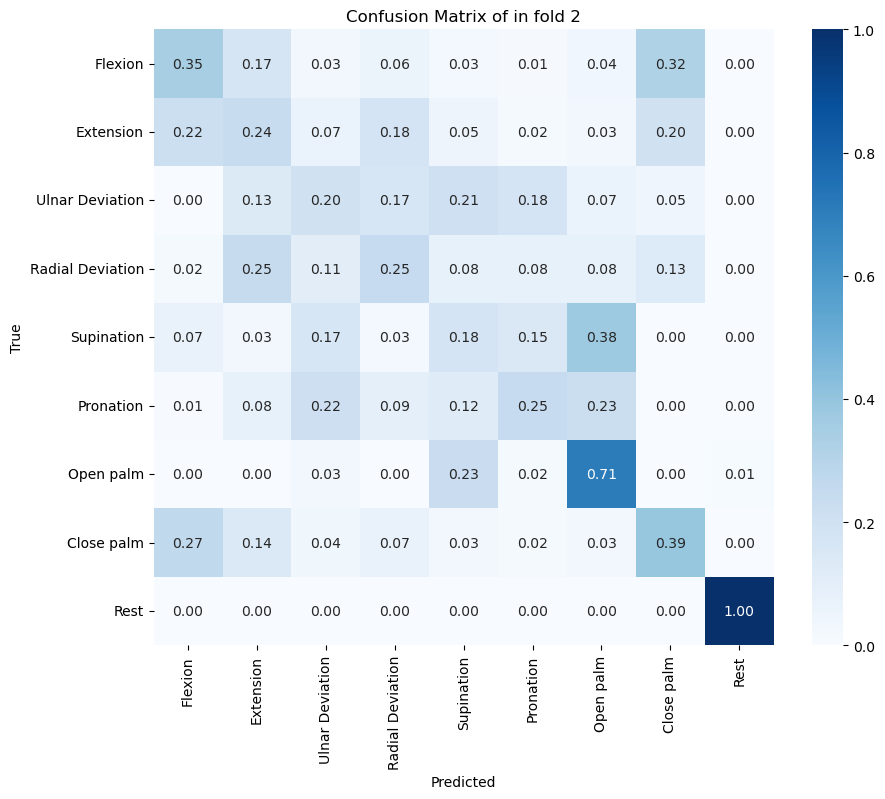

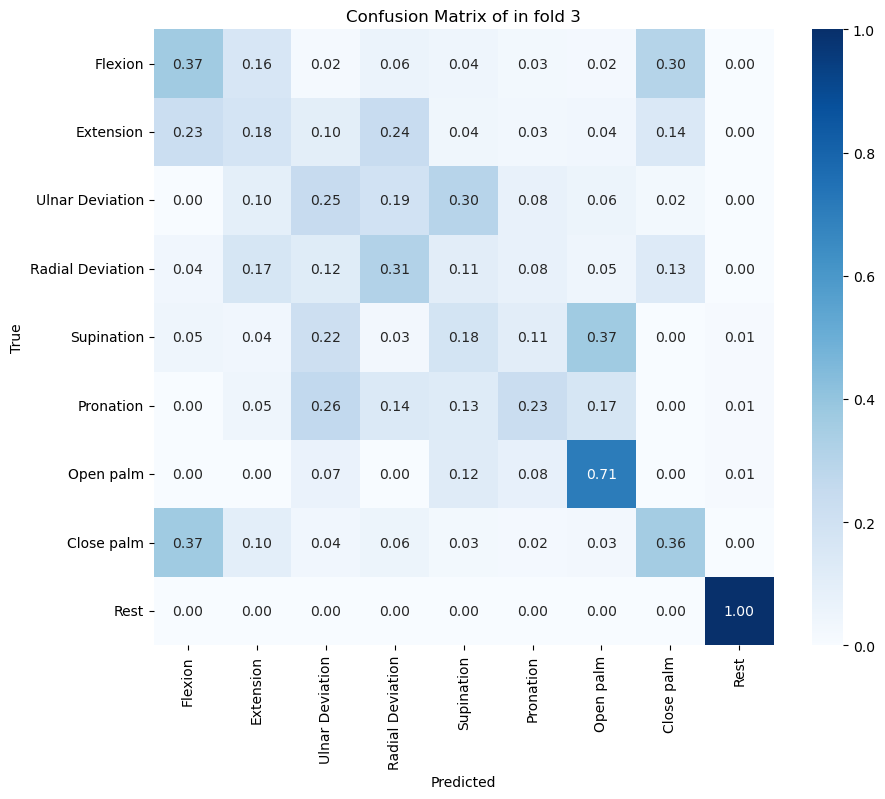

In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize variables to accumulate predictions and true labels
class_names = ['Flexion', 'Extension', 'Ulnar Deviation', 'Radial Deviation',
               'Supination', 'Pronation', 'Open palm', 'Close palm', 'Rest']

conf_matrices_logReg_list = []


for k_fold in range(3):

    # Load the trained model
    reg = load(f'LogisticRegression_fold_{k_fold+1}_app3.joblib')

    # Make predictions on the test data
    predictions = reg.predict(X_test[k_fold])
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test[k_fold], predictions)
    conf_matrices_logReg_list.append(conf_matrix)

    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix of in fold {k_fold+1}')
    plt.show()

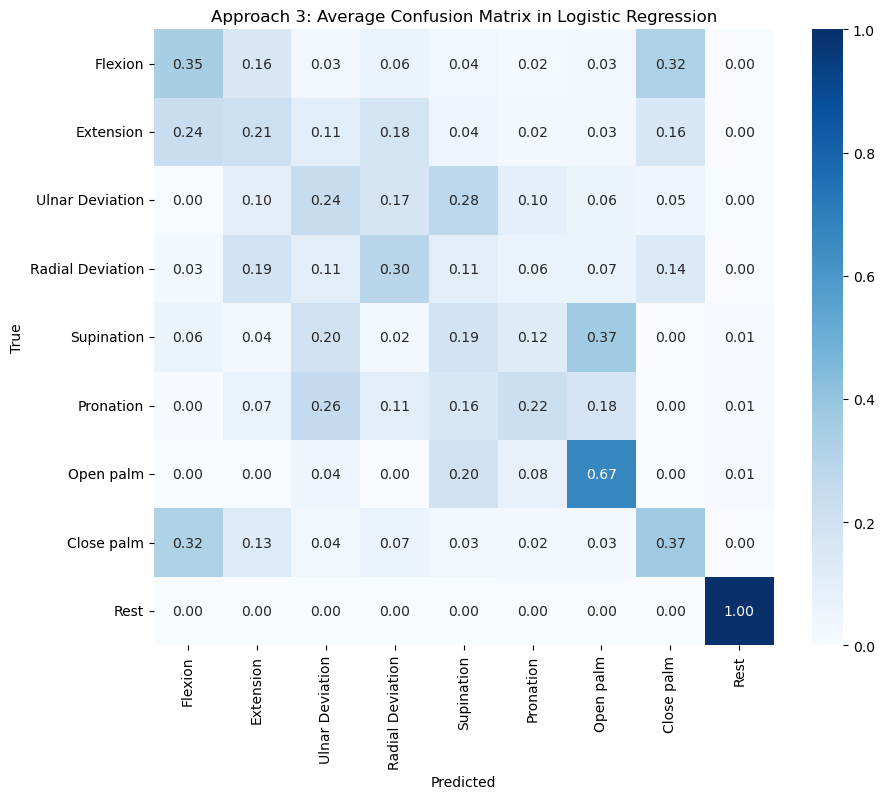

In [4]:
average_conf_matrix_LogReg = np.mean(conf_matrices_logReg_list, axis=0)
average_total_LogReg_samples_per_class = np.sum(average_conf_matrix_LogReg, axis=1)
average_conf_LogReg_matrix_percent = average_conf_matrix_LogReg / average_total_LogReg_samples_per_class[:, None]
# Plot the average confusion matrix
plt.figure(figsize=(10, 8))

sns.heatmap(average_conf_LogReg_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Approach 3: Average Confusion Matrix in Logistic Regression')
plt.show()

3. Feed Forward Neural Network

In [12]:
alltrainloader_list = []

for k_fold in range(3):
    all_train_dataset = CustomSignalData(get_tensor(X_train[k_fold]), get_tensor(y_train[k_fold]))
    alltrainloader = torch.utils.data.DataLoader(all_train_dataset, batch_size = 102, shuffle=True)
    alltrainloader_list.append(alltrainloader)

In [13]:
for alltrainloader in alltrainloader_list:
    print(alltrainloader)

Training 

In [14]:
inputDim = 8     # takes variable 'x' 
outputDim = 9      # takes variable 'y'
learningRate = 0.005

for k_fold in range(3):
    model = FFNN(inputDim, outputDim)
    model = model.to(DEVICE)

    crit = torch.nn.CrossEntropyLoss()
    acc_record = []
    params_clf = list(model.parameters())# + list(encoder.parameters())
    optim = torch.optim.Adam(params_clf, lr=learningRate)

    epochs = 200
    #encoder = encoder.to(device)
    for epoch in range(epochs):
        model.train()

        # Converting inputs and labels to Variable
        for inputs, labels, _, _ in alltrainloader_list[k_fold]:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            labels = labels.long()
            labels = labels.flatten()
            outputs = model(inputs, None)
            optim.zero_grad()
            # get loss for the predicted output
            losss = crit(outputs, labels) #+ 0.001 * model.l1_regula()
            # get gradients w.r.t to parameters
            losss.backward()
            # update parameters
            optim.step()

    torch.save(model.state_dict(), f"modelwoOperator_fold_{k_fold+1}_app3.pt")


Testing Feed Forward Neural Network

In [15]:
accuracies_FFNN_list = []


for k_fold in range(3):
    modelWOoperator = FFNN(8,9)
    modelWOoperator.load_state_dict(torch.load(f"modelwoOperator_fold_{k_fold+1}_app3.pt")) # loaded from the file: parameters learned during training.
    modelWOoperator.eval()

    test_shift_dataset = CustomSignalData(get_tensor(X_test[k_fold]), get_tensor(y_test[k_fold]))
    testshiftloader = torch.utils.data.DataLoader(test_shift_dataset, batch_size=24, shuffle=True)
    accuracies_FFNN_list.append(clf_acc(modelWOoperator, testshiftloader, encoder = None))


print(accuracies_FFNN_list)

[0.6639901404045266, 0.6556806716918945, 0.644505846956277]


In [20]:
value_average_accuracies_FFNN = sum(accuracies_FFNN_list) / 3 
print(value_average_accuracies_FFNN)

0.6547255530175661


/tmp/ipykernel_19184/1040929989.py:34: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]


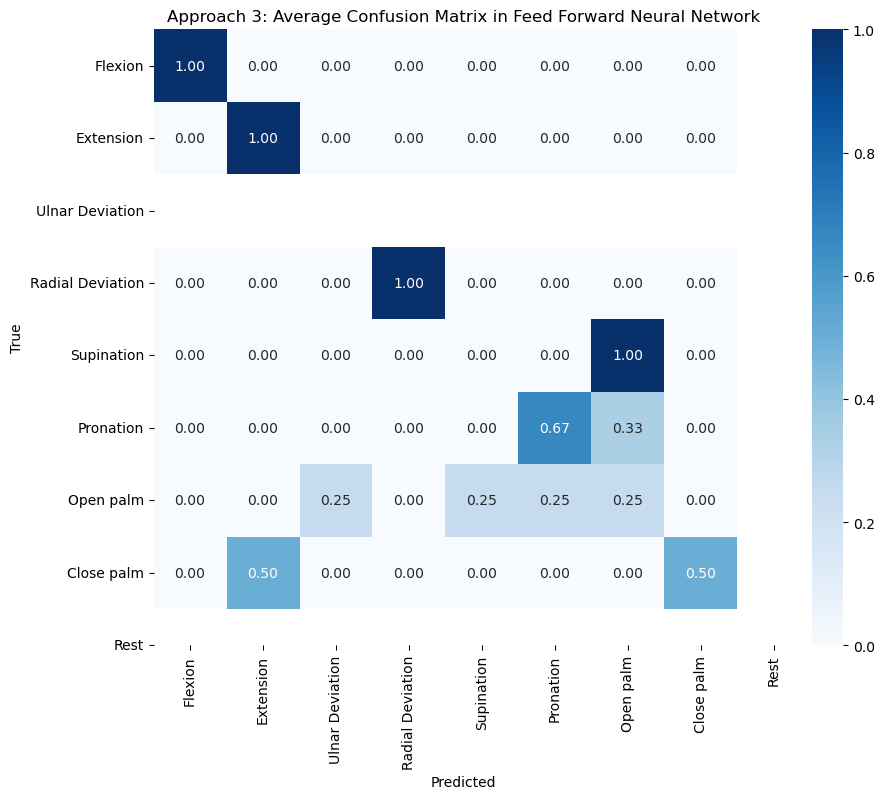

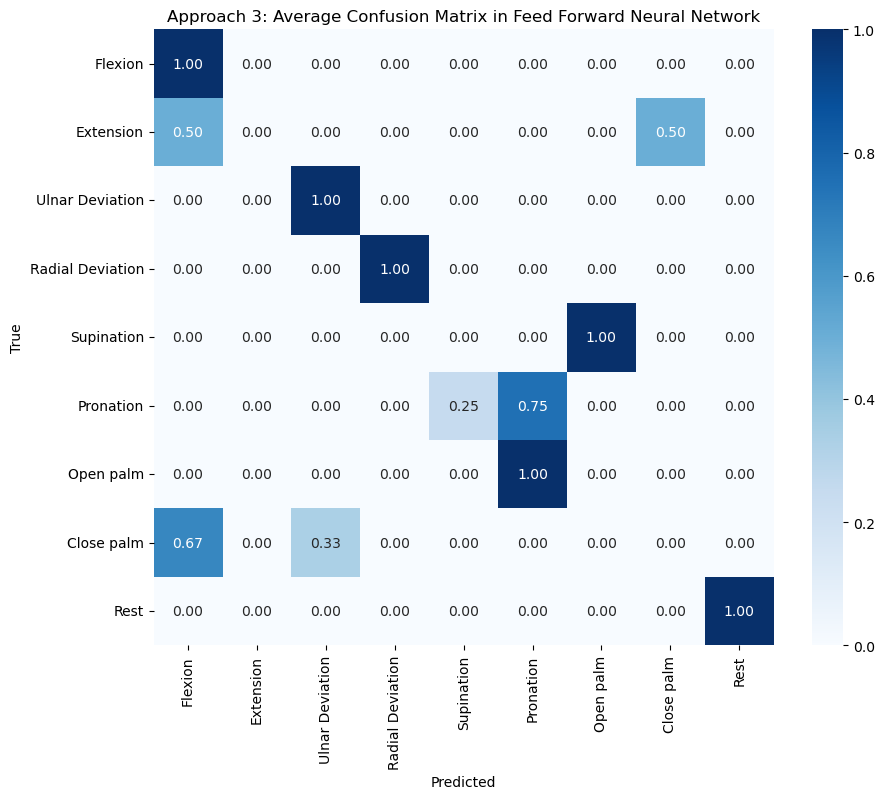

/tmp/ipykernel_19184/1040929989.py:34: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]


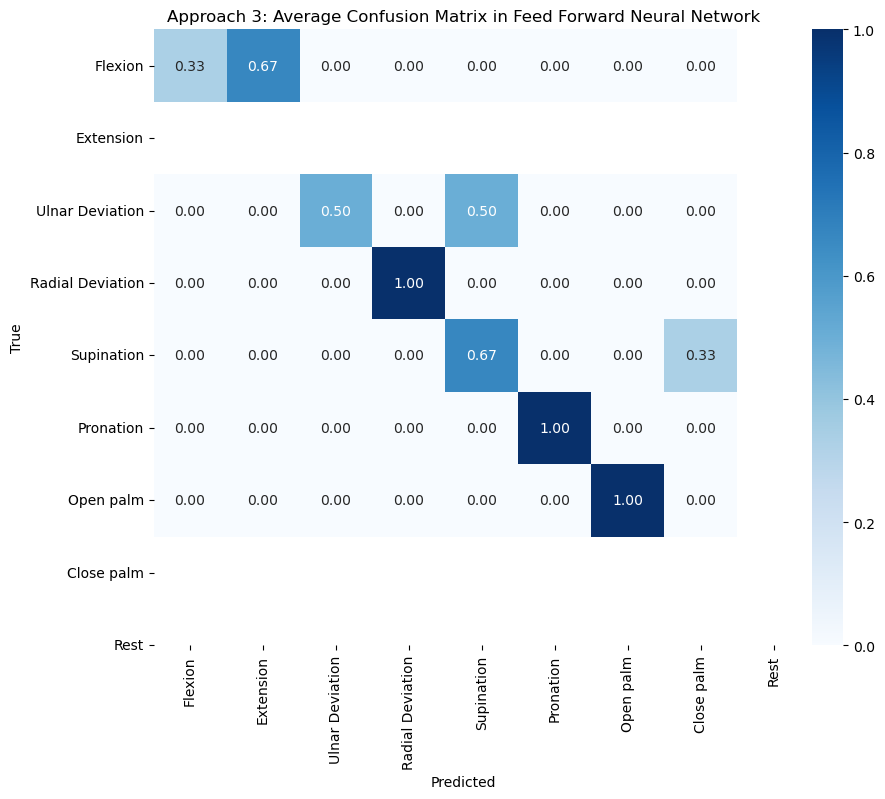

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize variables to accumulate predictions and true labels
conf_matrices_FFNN = []
# Define class names
class_names = ['Flexion', 'Extension', 'Ulnar Deviation', 'Radial Deviation',
               'Supination', 'Pronation', 'Open palm', 'Close palm', 'Rest']
# Initialize variables to accumulate predictions and true labels

for k_fold in range(3):
    # Load the trained model
    modelWOoperator = FFNN(8, 9)
    modelWOoperator.load_state_dict(torch.load(f"modelwoOperator_fold_{k_fold+1}_app3.pt"))
    modelWOoperator.eval()

    # Prepare the test dataset
    test_shift_dataset = CustomSignalData(get_tensor(X_test[k_fold]), get_tensor(y_test[k_fold]))
    test_shift_loader = torch.utils.data.DataLoader(test_shift_dataset, batch_size=24, shuffle=True)

    with torch.no_grad():
        for inputs, labels,_,_ in test_shift_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            pred = modelWOoperator(inputs)
            predicted = torch.argmax(pred,dim = 1)
    # Calculate the confusion matrix for the current shift
    conf_matrix = confusion_matrix(labels.tolist(), predicted.tolist())
    conf_matrices_FFNN.append(conf_matrix)
    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]


    # Plot the average confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Approach 3: Average Confusion Matrix in Feed Forward Neural Network')
    plt.show()

In [25]:
average_conf_matrix_FFNN = np.mean(conf_matrices_FFNN, axis=0)
average_total_samples_per_class_FFNN = np.sum(average_conf_matrix_FFNN, axis=1)
average_conf_matrix_percent_FFNN = average_conf_matrix_FFNN / average_total_samples_per_class_FFNN[:, None]
# Plot the average confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(average_conf_matrix_percent_FFNN, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix of total 9 shifts in LOgistic Regression')
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

4. Self-supervised Learning

In [16]:
triplettrainloader_list = []

for k_fold in range(3):
    all_X_train, all_y_train, all_shift_train = get_all_data(X_train[k_fold], y_train[k_fold])
    all_X1_train, all_X2_train, all_shift_1_train, all_shift_2_train, all_y_shift_train = get_shift_data(all_X_train, all_shift_train, all_y_train)

    triplet_train_dataset = CustomSignalData1(get_tensor(all_X1_train), get_tensor(all_X2_train), get_tensor(all_shift_1_train), get_tensor(all_shift_2_train), get_tensor(all_y_shift_train))
    triplettrainloader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size = 102, shuffle=True)
    triplettrainloader_list.append(triplettrainloader)

In [17]:
print(triplettrainloader_list)

[<torch.utils.data.dataloader.DataLoader object at 0x7fbf2c42d1e0>, <torch.utils.data.dataloader.DataLoader object at 0x7fbf2c53fd60>, <torch.utils.data.dataloader.DataLoader object at 0x7fbf2d1b4d90>]


Training

In [19]:
for k_fold in range(3):
    all_X_train, all_y_train, all_shift_train = get_all_data(X_train[k_fold], y_train[k_fold])

    encoder = E(8,8)
    encoder.to(DEVICE)
    classifier = FFNN(8,9)
    classifier.to(DEVICE)

    parameters = list(encoder.parameters()) + list(classifier.parameters())

    crit1 = torch.nn.MSELoss()
    crit2 = torch.nn.CrossEntropyLoss()
    crit1.to(DEVICE)
    crit2.to(DEVICE)
    loss_record = []

    optimizer = torch.optim.Adam(parameters, lr=0.002)
    n_epochs = 50

    for epoch in range(0,n_epochs):
        encoder.train()
        classifier.train()
        for inputs1, inputs2, shift1, shift2, labels, _ in triplettrainloader_list[k_fold]:
            inputs1 = inputs1.to(DEVICE)
            inputs2 = inputs2.to(DEVICE)
            shift1 = -shift1.int().flatten().to(DEVICE)
            shift2 = -shift2.int().flatten().to(DEVICE)
            labels = labels.long().flatten().to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y1 = encoder(inputs1)
            y_tr_est1 = rotate_batch(y1,shift1,6)
            y_tr1 = classifier(y_tr_est1)


            y2 = encoder(inputs2)
            y_tr_est2 = rotate_batch(y2,shift2,6)
            y_tr2 = classifier(y_tr_est2)

            loss =  crit1(y_tr_est1, y_tr_est2) + 0.5*crit2(y_tr1,labels)+ 0.5*crit2(y_tr2,labels)
            loss.backward()
            optimizer.step()

    torch.save(classifier.state_dict(), f"classifier_fold_{k_fold+1}_app3.pt")
    torch.save(encoder.state_dict(), f"encoder_fold_{k_fold+1}_app3.pt")
    with torch.no_grad():
        encoder.eval()
        N_points = 1000
        rand_idx = np.random.choice(all_X_train.shape[0], N_points)
        y_tr = encoder(get_tensor(all_X_train[rand_idx]))
        recovered_points_ = rotate_batch(y_tr,-all_shift_train[rand_idx].flatten(), 6)
        del y_tr

    torch.save(recovered_points_, f"reference_points_fold_{k_fold+1}_app3.pt")

Testing Self-supervised Learning

In [7]:
DEVICE = torch.device("cpu") # operations is in CPU or GPU.
M = torch.diag(torch.ones(8)).roll(-1,1) # Create a diagnoise matrix then shift it to the right
used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)] #

N_points = 1000

accuracies_self_supervised_list = []


for k_fold in range(3):
    classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
    encoder = E(8,8)
    encoder.load_state_dict(torch.load(f"encoder_fold_{k_fold+1}_app3.pt")) # contains the learned parameters (weights and biases) of the encoder model
    recovered_points_= torch.load(f"reference_points_fold_{k_fold+1}_app3.pt") # These points represent reference points for inference or evaluation in the model
    classifier.load_state_dict(torch.load(f"classifier_fold_{k_fold+1}_app3.pt")) # contains the weights and biases learned during training.
    classifier.eval() # sets the model to evaluation mode.
    encoder.eval() # sets the model to evaluation mode.

    # Get the test data for the current shift and fold
    X_test_shift = X_test[k_fold]

    # Encode the test data using the encoder model
    y1 = encoder(get_tensor(X_test_shift))

    # Use the encoded data directly without rotation
    y_tr1 = classifier(y1).argmax(1)

    # Calculate accuracy and append to list
    accuracies_self_supervised_list.append((1 - torch.abs(torch.sign(y_tr1 - get_tensor(y_test[k_fold]).flatten()))).mean().item())

print(accuracies_self_supervised_list)

[0.7285605072975159, 0.7102843523025513, 0.7335205078125]


In [8]:
print(sum(accuracies_self_supervised_list)/3)

0.7241217891375223


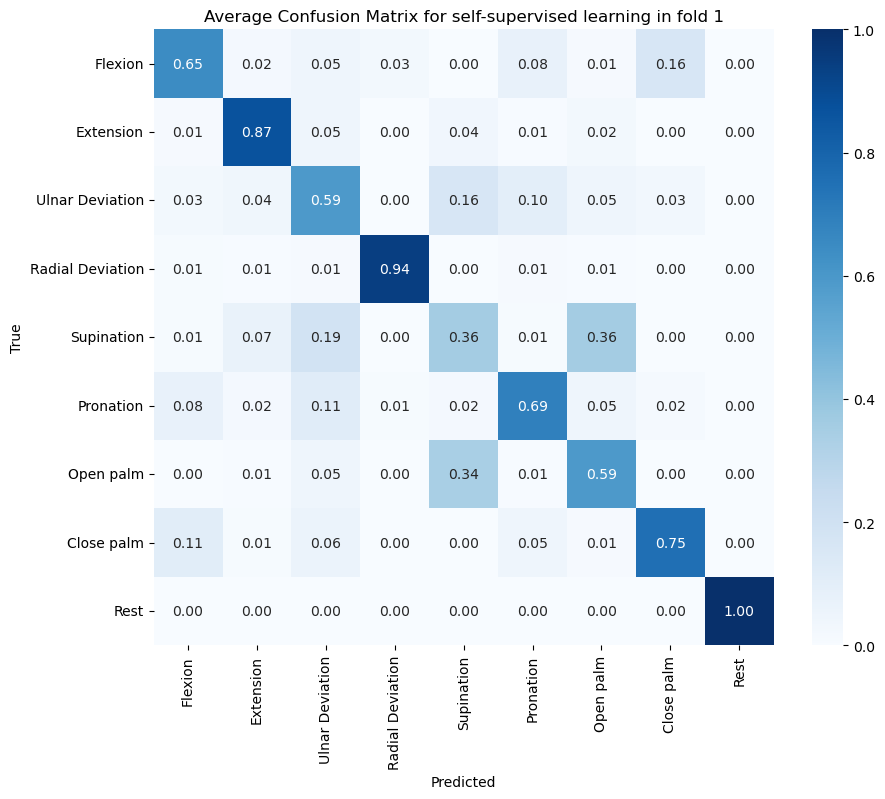

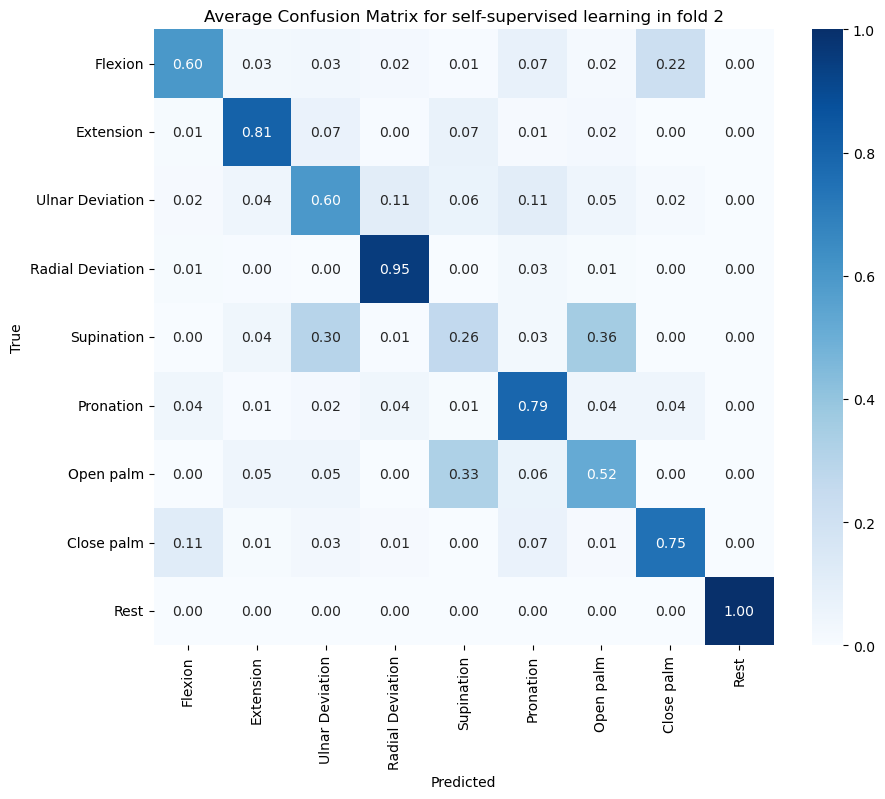

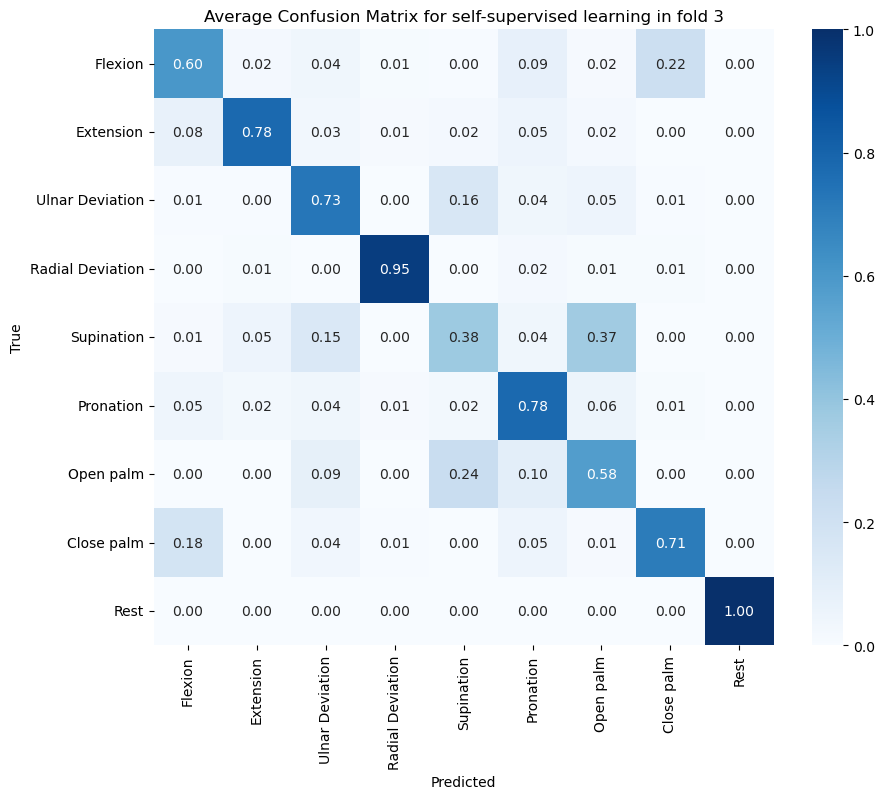

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize variables to accumulate predictions and true labels
conf_matrices_self_supervised = []
class_names = ['Flexion', 'Extension', 'Ulnar Deviation', 'Radial Deviation',
               'Supination', 'Pronation', 'Open palm', 'Close palm', 'Rest']
# Loop through shifts and folds

for k_fold in range(3):
    #classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
    encoder = E(8,8)
    encoder.load_state_dict(torch.load(f"encoder_fold_{k_fold+1}_app3.pt")) # contains the learned parameters (weights and biases) of the encoder model
    recovered_points_= torch.load(f"reference_points_fold_{k_fold+1}_app3.pt") # These points represent reference points for inference or evaluation in the model
    classifier.load_state_dict(torch.load(f"classifier_fold_{k_fold+1}_app3.pt")) # contains the weights and biases learned during training.
    classifier.eval() # sets the model to evaluation mode.
    encoder.eval() # sets the model to evaluation mode.

    # Get the test data for the current shift and fold
    X_test_shift = X_test[k_fold]
    # Encode the test data using the encoder model
    y1 = encoder(get_tensor(X_test_shift))
    # Use the encoded data directly without rotation
    y_tr1 = classifier(y1).argmax(1)
     
    # Calculate the confusion matrix for the current shift
    conf_matrix = confusion_matrix(get_tensor(y_test[k_fold]).flatten(), y_tr1.cpu().numpy())
    conf_matrices_self_supervised.append(conf_matrix)

    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]


    # Plot the average confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Average Confusion Matrix for self-supervised learning in fold {k_fold+1}')
    plt.show()


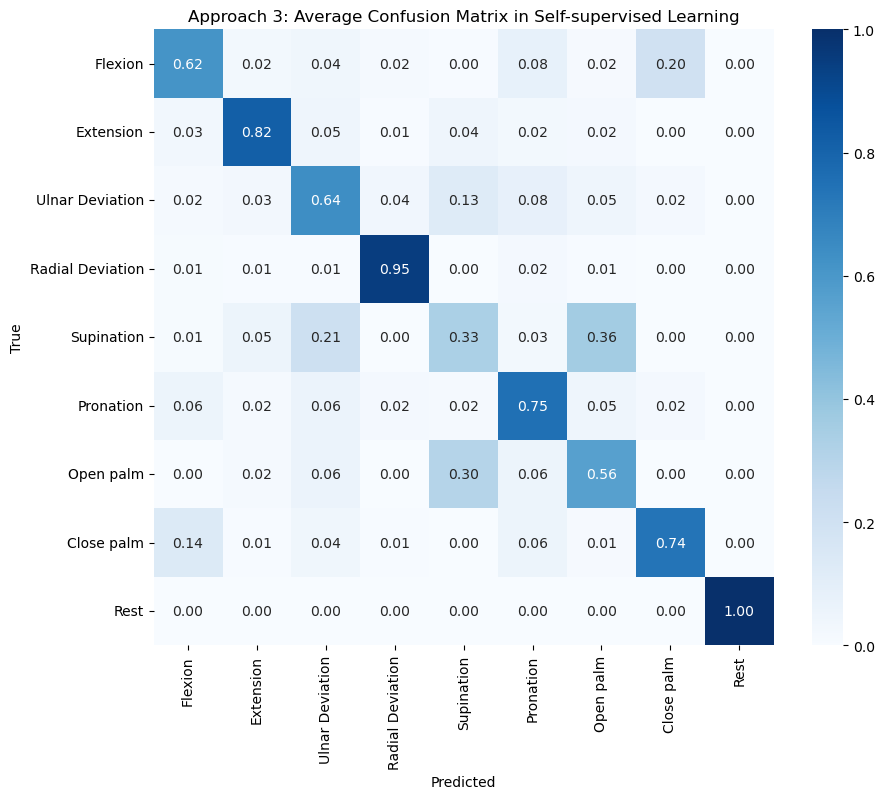

In [10]:
average_conf_matrix__self_supervised = np.mean(conf_matrices_self_supervised, axis=0)
average_total__self_supervised_samples_per_class = np.sum(average_conf_matrix__self_supervised, axis=1)
average_conf__self_supervised_matrix_percent = average_conf_matrix__self_supervised / average_total__self_supervised_samples_per_class[:, None]
# Plot the average confusion matrix
plt.figure(figsize=(10, 8))

sns.heatmap(average_conf__self_supervised_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Approach 3: Average Confusion Matrix in Self-supervised Learning')
plt.show()

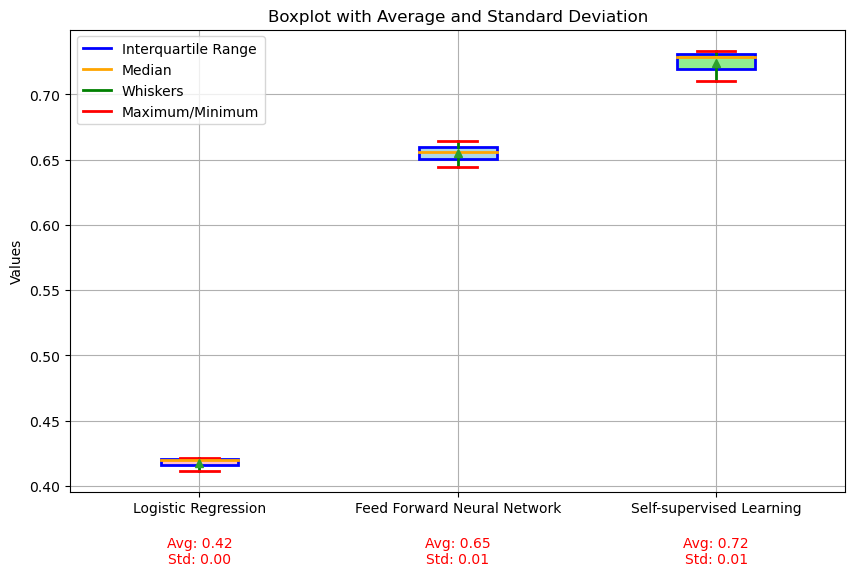

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = [
    [0.41190498902985784, 0.4197589672748059, 0.4212079386987768],
    [0.6639901404045266, 0.6556806716918945, 0.644505846956277],
    [0.7285605072975159, 0.7102843523025513, 0.7335205078125]
]

# Calculate average and standard deviation
averages = [np.mean(lst) for lst in data]
std_devs = [np.std(lst) for lst in data]

# Plot boxplot with customized colors and statistics
plt.figure(figsize=(10, 6))
colors = ['pink', 'lightblue', 'lightgreen']
boxprops = dict(color="blue", linewidth=2)
medianprops = dict(color="orange", linewidth=2)
whiskerprops = dict(color="green", linewidth=2)
capprops = dict(color="red", linewidth=2)
box = plt.boxplot(data, showmeans=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks([1, 2, 3], ['Logistic Regression', 'Feed Forward Neural Network', 'Self-supervised Learning'])
plt.ylabel('Values')
plt.title('Boxplot with Average and Standard Deviation')
plt.grid(True)

# Add legend explaining box components
legend_elements = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Interquartile Range'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Median'),
    plt.Line2D([0], [0], color='green', lw=2, label='Whiskers'),
    plt.Line2D([0], [0], color='red', lw=2, label='Maximum/Minimum')
]
plt.legend(handles=legend_elements)

# Add average and standard deviation text below the graph
for i in range(len(data)):
    plt.text(i + 1, min(np.min(lst) for lst in data) - 0.05, f'Avg: {averages[i]:.2f}\nStd: {std_devs[i]:.2f}', horizontalalignment='center', verticalalignment='top', fontsize=10, color='red')

plt.show()
